In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Sep 18 16:29:01 PDT 2019


# Table of % SAM and delta SAM by scenario and by location

In [2]:
%cd /share/costeffectiveness/results/vivarium_conic_sam_comparison

/ihme/costeffectiveness/results/vivarium_conic_sam_comparison


In [3]:
import glob
# sorted(glob.glob('*/*/output.hdf'))

In [4]:
location_list = ['India', 'Bangladesh', 'Pakistan', 'Tanzania', 'Malawi', 'Mali']
fname = {}
for loc in location_list:
    fname[loc] = sorted(glob.glob(f'vivarium_conic_sam_comparison_{loc}/*/output.hdf'))[-1]
fname

{'India': 'vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf',
 'Bangladesh': 'vivarium_conic_sam_comparison_Bangladesh/2019_09_12_16_06_24/output.hdf',
 'Pakistan': 'vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf',
 'Tanzania': 'vivarium_conic_sam_comparison_Tanzania/2019_09_12_14_36_50/output.hdf',
 'Malawi': 'vivarium_conic_sam_comparison_Malawi/2019_09_12_14_36_29/output.hdf',
 'Mali': 'vivarium_conic_sam_comparison_Mali/2019_09_12_14_36_37/output.hdf'}

In [5]:
df = {}
for loc in location_list:
    df[loc] = pd.read_hdf(fname[loc])
    print(loc, len(df[loc]))

India 4000
Bangladesh 4000
Pakistan 4000
Tanzania 4000
Malawi 4000
Mali 4000


In [6]:
for loc in location_list:
    del df[loc]['random_seed']

In [7]:
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]

for loc in location_list:
    g = df[loc].reset_index().groupby(scenarios + ['input_draw_number'])
    print(f'{loc} has {len(g.groups)} groups, with {len(df[loc])/len(g.groups):.2f} reps per group')
    df[loc] = g.sum()


India has 400 groups, with 10.00 reps per group
Bangladesh has 400 groups, with 10.00 reps per group
Pakistan has 400 groups, with 10.00 reps per group
Tanzania has 400 groups, with 10.00 reps per group
Malawi has 400 groups, with 10.00 reps per group
Mali has 400 groups, with 10.00 reps per group


In [8]:
def scenario_map_generator():
    baseline = (0,0,0)
    bep = (.8, 0, 0)
    sqlns = (0, .8, 0)
    tfsam = (0, 0, .8)
    scenario_map = dict(baseline=baseline, bep=bep, sqlns=sqlns, tfsam=tfsam)

    return scenario_map
scenario_map = scenario_map_generator()

In [9]:
def pct_sam(df, scenario):
    
    scenario = scenario_map[scenario]
    
    t = df.loc[scenario].filter(like='child_wasting').div(
        df.loc[scenario].filter(like='child_wasting').sum(axis=1), axis='rows')

    t = 100*t['child_wasting_cat1_exposed']
    t.name = 'pct_sam'
    
    return t
pct_sam(df[loc], 'baseline').describe()

count    100.000000
mean       3.071322
std        0.196700
min        2.566046
25%        2.946155
50%        3.066149
75%        3.206927
max        3.547969
Name: pct_sam, dtype: float64

In [10]:
np.round(pct_sam(df['India'], 'baseline').describe(percentiles=[.025, .975]), 2)

count    100.00
mean       4.77
std        0.07
min        4.59
2.5%       4.66
50%        4.77
97.5%      4.91
max        4.95
Name: pct_sam, dtype: float64

In [11]:
np.round(pct_sam(df['Mali'], 'baseline').describe(percentiles=[.025, .975]), 2)

count    100.00
mean       3.07
std        0.20
min        2.57
2.5%       2.71
50%        3.07
97.5%      3.48
max        3.55
Name: pct_sam, dtype: float64

In [12]:
# TODO: make a bar chart, or HOP plot of SAM prevalence rates
# TODO: make a circle map of SAM prevance counts

In [13]:
import pymc as pm

In [14]:
def my_formatted_output(s):
    mu = f'{s.mean():.2f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{lb:.2f}'
    ub = f'{ub:.2f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu, 'lb':lb, 'ub':ub}
my_formatted_output(pct_sam(df['Mali'], 'baseline'))

{'mean': '3.07', 'lb': '2.72', 'ub': '3.49'}

In [15]:
my_formatted_output(pct_sam(df['India'], 'baseline'))

{'mean': '4.77', 'lb': '4.63', 'ub': '4.89'}

In [16]:
results = {}

for loc in location_list:
    sam_0 = pct_sam(df[loc], 'baseline')
    for scenario in ['baseline', 'bep', 'sqlns', 'tfsam']:
        sam_1 = pct_sam(df[loc], scenario)
        results[loc, scenario, 'pct'] = my_formatted_output(sam_1)
        if scenario != 'baseline':
            results[loc, scenario, 'delta_abs'] = my_formatted_output(sam_0-sam_1)
            results[loc, scenario, 'delta_rel'] = my_formatted_output(100*(sam_0-sam_1)/sam_0)
results = pd.DataFrame(results)        

In [17]:
results = results.T.unstack().unstack().dropna(axis=1, how='all')

In [18]:
col_to_sort = (0, 'pct', 'baseline')
col_to_sort = ('mean', 'pct', 'baseline')
results.sort_values(col_to_sort, ascending=False)

mean                                                          \
           delta_abs             delta_rel                   pct               
                 bep sqlns tfsam       bep sqlns  tfsam baseline   bep sqlns   
India           0.67  0.18  1.33     14.07  3.78  27.93     4.77  4.10  4.59   
Mali            0.50  0.14  0.72     16.29  4.58  23.51     3.07  2.57  2.93   
Pakistan        0.49  0.14  0.67     16.96  4.94  23.19     2.89  2.40  2.75   
Bangladesh      0.48  0.14  0.74     17.34  5.15  26.93     2.78  2.30  2.64   
Tanzania        0.19  0.05  0.31     19.96  5.20  33.31     0.94  0.76  0.90   
Malawi          0.15  0.04  0.23     20.48  5.84  32.25     0.71  0.57  0.67   

                  ...        ub                                              \
                  ... delta_abs             delta_rel                   pct   
           tfsam  ...       bep sqlns tfsam       bep sqlns  tfsam baseline   
India       3.44  ...      0.72  0.24  1.39     14.91  4.97  29.02     4.89   
Mali        2.35  ...      0.55  0.18  0.90     17.58  6.12  29.35     3.49   
Pakistan    2.22  ...      0.55  0.20  0.99     18.15  6.53  32.69     3.27   
Bangladesh  2.04  ...      0.53  0.18  0.91     19.18  6.87  34.38     3.17   
Tanzania    0.63  ...      0.21  0.07  0.37     21.81  7.32  37.49     1.06   
Malawi      0.48  ...      0.17  0.06  0.30     22.26  7.66  38.38     0.82   

                              
                              
             bep sqlns tfsam  
India       4.22  4.74  3.55  
Mali        2.96  3.33  2.85  
Pakistan    2.73  3.14  2.64  
Bangladesh  2.65  3.01  2.54  
Tanzania    0.85  1.00  0.71  
Malawi      0.67  0.77  0.58  

[6 rows x 30 columns]

In [19]:
results.loc[location_list]

mean                                                          \
           delta_abs             delta_rel                   pct               
                 bep sqlns tfsam       bep sqlns  tfsam baseline   bep sqlns   
India           0.67  0.18  1.33     14.07  3.78  27.93     4.77  4.10  4.59   
Bangladesh      0.48  0.14  0.74     17.34  5.15  26.93     2.78  2.30  2.64   
Pakistan        0.49  0.14  0.67     16.96  4.94  23.19     2.89  2.40  2.75   
Tanzania        0.19  0.05  0.31     19.96  5.20  33.31     0.94  0.76  0.90   
Malawi          0.15  0.04  0.23     20.48  5.84  32.25     0.71  0.57  0.67   
Mali            0.50  0.14  0.72     16.29  4.58  23.51     3.07  2.57  2.93   

                  ...        ub                                              \
                  ... delta_abs             delta_rel                   pct   
           tfsam  ...       bep sqlns tfsam       bep sqlns  tfsam baseline   
India       3.44  ...      0.72  0.24  1.39     14.91  4.97  29.02     4.89   
Bangladesh  2.04  ...      0.53  0.18  0.91     19.18  6.87  34.38     3.17   
Pakistan    2.22  ...      0.55  0.20  0.99     18.15  6.53  32.69     3.27   
Tanzania    0.63  ...      0.21  0.07  0.37     21.81  7.32  37.49     1.06   
Malawi      0.48  ...      0.17  0.06  0.30     22.26  7.66  38.38     0.82   
Mali        2.35  ...      0.55  0.18  0.90     17.58  6.12  29.35     3.49   

                              
                              
             bep sqlns tfsam  
India       4.22  4.74  3.55  
Bangladesh  2.65  3.01  2.54  
Pakistan    2.73  3.14  2.64  
Tanzania    0.85  1.00  0.71  
Malawi      0.67  0.77  0.58  
Mali        2.96  3.33  2.85  

[6 rows x 30 columns]

In [20]:
results.loc[location_list, ('mean', 'pct')]

,baseline,bep,sqlns,tfsam
India,4.77,4.10,4.59,3.44
Bangladesh,2.78,2.30,2.64,2.04
Pakistan,2.89,2.40,2.75,2.22
Tanzania,0.94,0.76,0.90,0.63
Malawi,0.71,0.57,0.67,0.48
Mali,3.07,2.57,2.93,2.35


In [21]:
results.loc[location_list, ('mean', 'delta_abs')]

,bep,sqlns,tfsam
India,0.67,0.18,1.33
Bangladesh,0.48,0.14,0.74
Pakistan,0.49,0.14,0.67
Tanzania,0.19,0.05,0.31
Malawi,0.15,0.04,0.23
Mali,0.50,0.14,0.72


In [22]:
results.loc[location_list, ('mean', 'delta_rel')]

,bep,sqlns,tfsam
India,14.07,3.78,27.93
Bangladesh,17.34,5.15,26.93
Pakistan,16.96,4.94,23.19
Tanzania,19.96,5.20,33.31
Malawi,20.48,5.84,32.25
Mali,16.29,4.58,23.51


In [23]:
results.loc[location_list, ('mean', 'pct', 'baseline')].to_dict()

{'India': '4.77',
 'Bangladesh': '2.78',
 'Pakistan': '2.89',
 'Tanzania': '0.94',
 'Malawi': '0.71',
 'Mali': '3.07'}

In [24]:
# compare to http://ihmeuw.org/4wg1 (GBD2017 1990-2017)
# or http://ihmeuw.org/4wgl (forecasts to 2040, based on GBD2016)
# but not too quantitatively, because that is SEV and this is cat1

In [25]:
import seaborn as sns
sns.set_context('talk', font_scale=1.5)

def set_plot_size():
    from IPython.core.pylabtools import figsize
    figsize(11, 5.5)
set_plot_size()

# Plot percent SAM by location and scenario

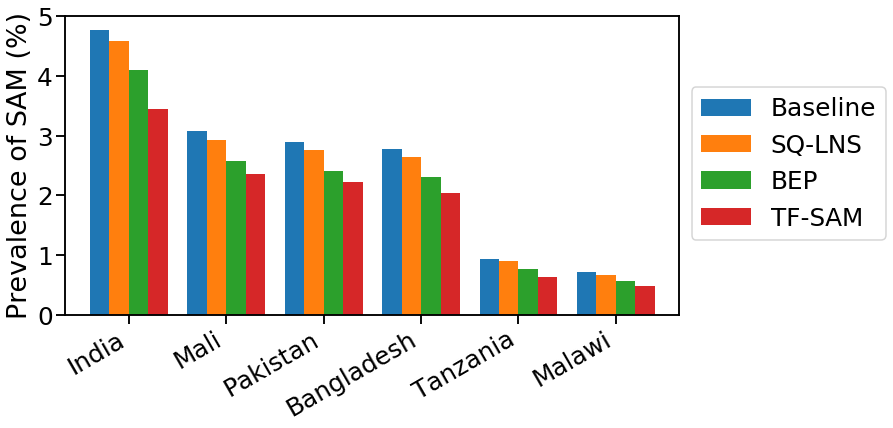

In [26]:
def my_plot(cols_to_blank=[]):
    t = results.loc[location_list, ('mean', 'pct')].astype(float)\
        .filter(['baseline', 'sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['Baseline', 'SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('Baseline', ascending=False)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('Prevalence of SAM (%)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

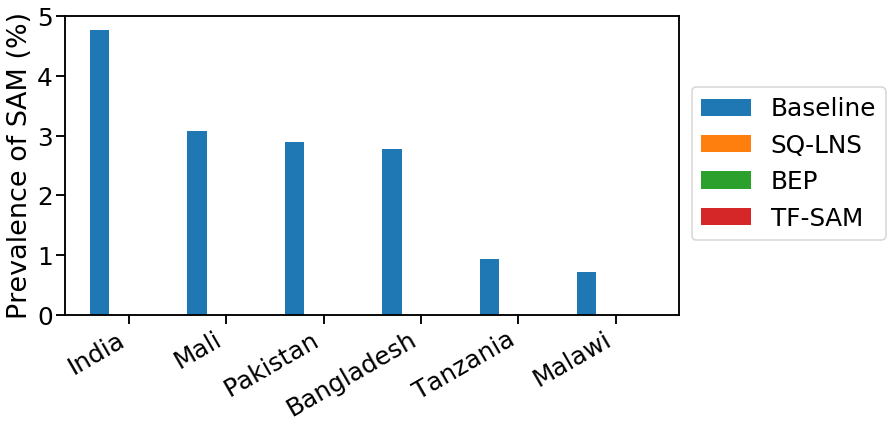

In [27]:
# series of similar plots to reveal results sequentially
my_plot(cols_to_blank=['sqlns', 'bep', 'tfsam'])

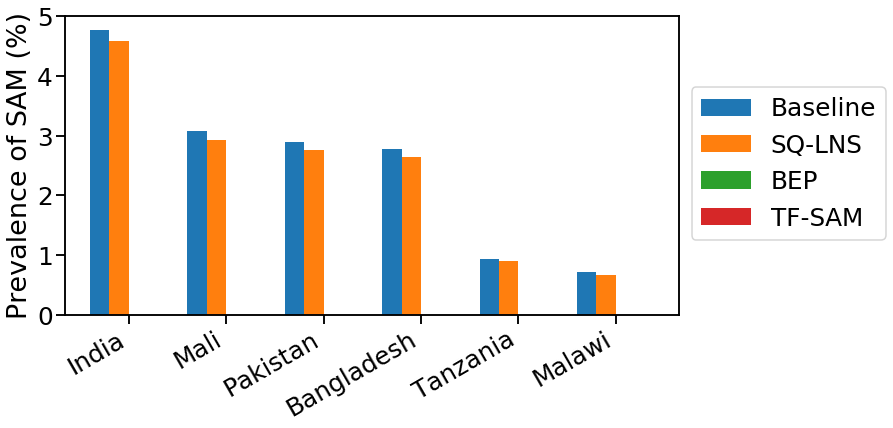

In [28]:
my_plot(cols_to_blank=['bep', 'tfsam'])

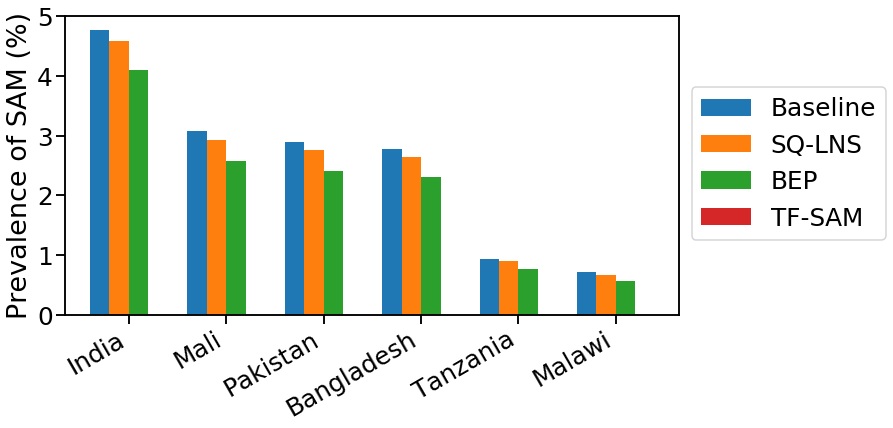

In [29]:
my_plot(cols_to_blank=['tfsam'])

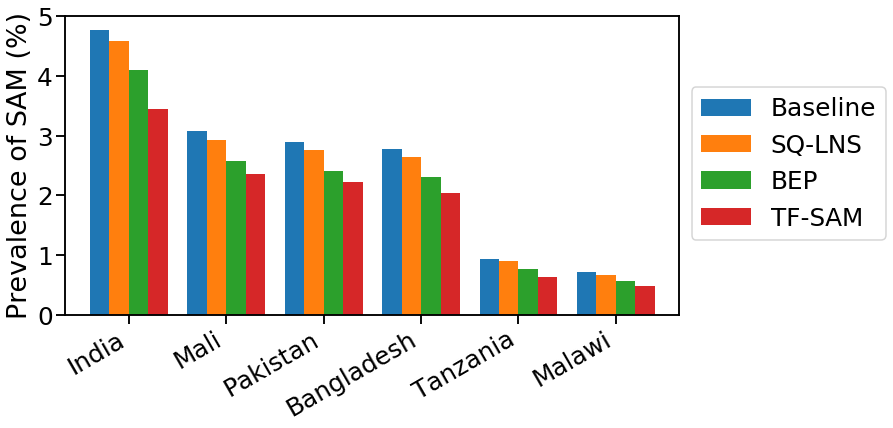

In [30]:
my_plot(cols_to_blank=[])

# Plot delta SAM by location and scenario

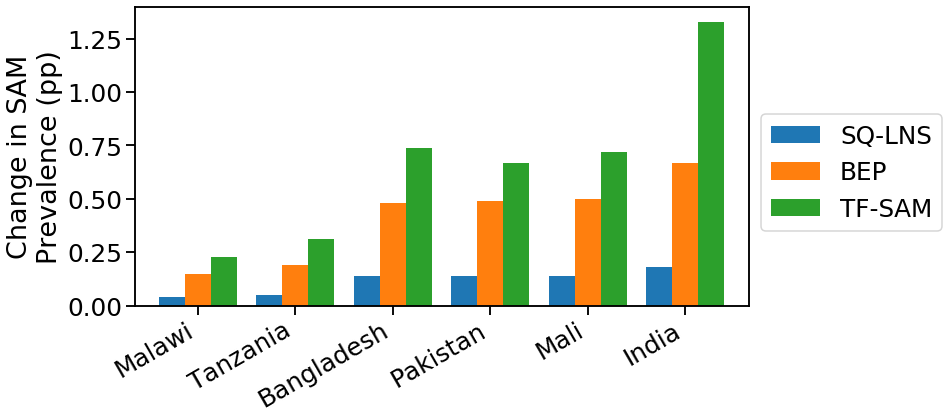

In [31]:
def my_plot(cols_to_blank=[]):
    t = results.loc[location_list, ('mean', 'delta_abs')].astype(float)\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
    plt.axis(ymax=1.4)
    plt.ylabel('Change in SAM\nPrevalence (pp)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

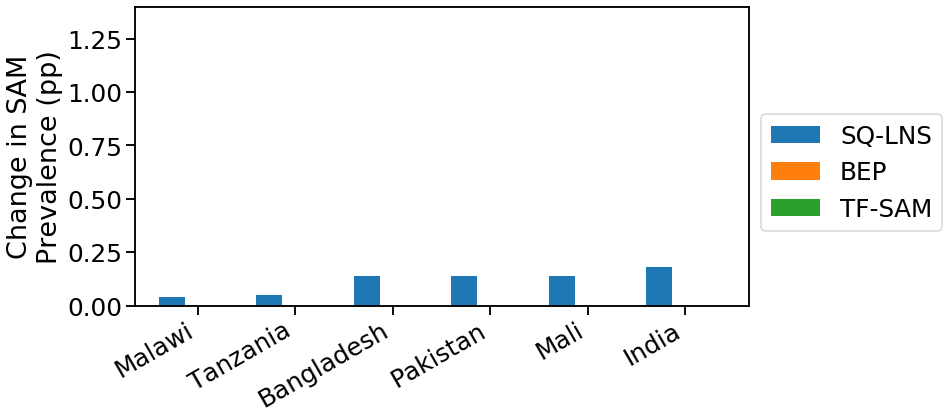

In [32]:
my_plot(cols_to_blank=['bep', 'tfsam'])

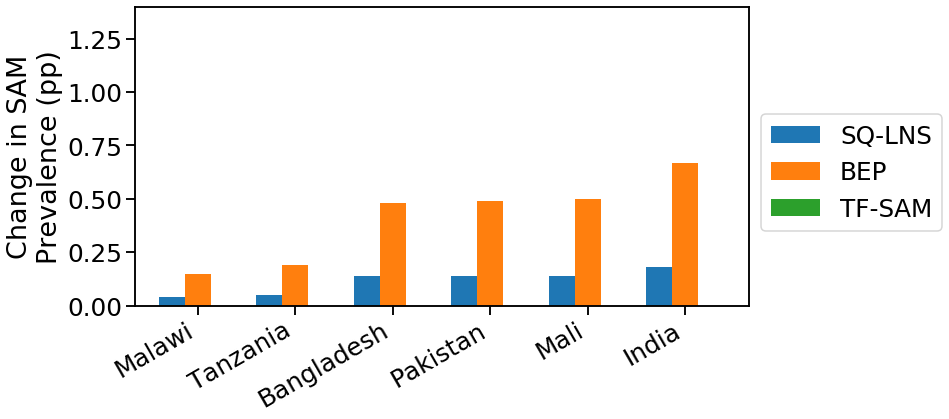

In [33]:
my_plot(cols_to_blank=['tfsam'])

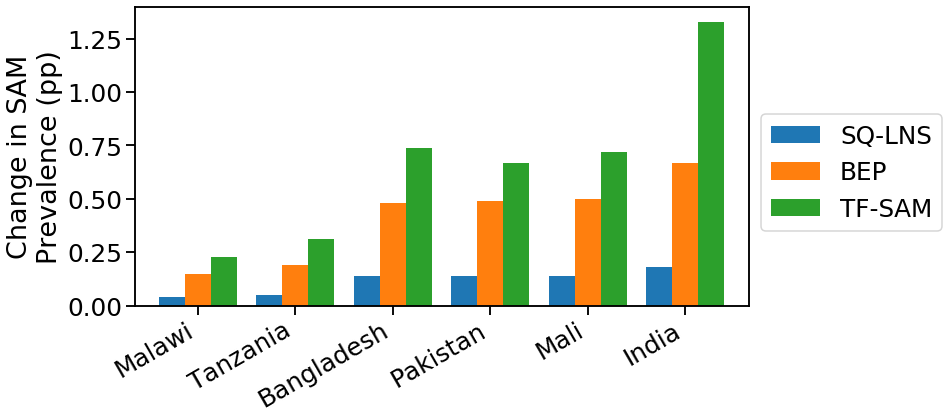

In [34]:
my_plot(cols_to_blank=[])

# Plot relative delta SAM by location and scenario

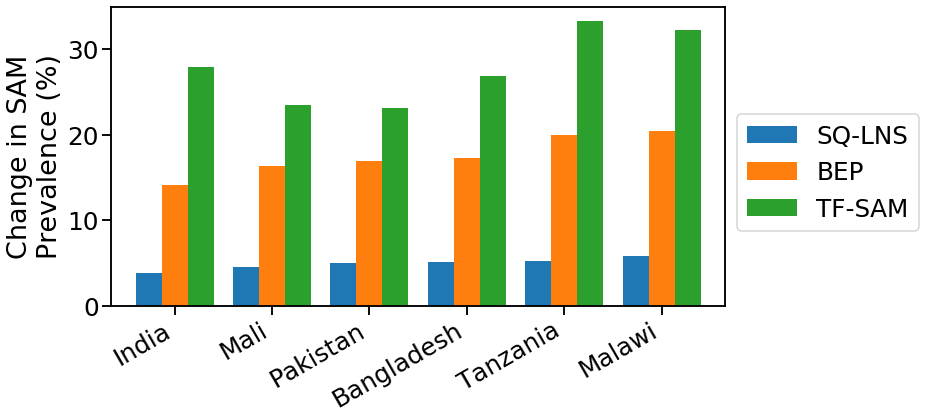

In [35]:
def my_plot(cols_to_blank=[]):
    t = results.loc[location_list, ('mean', 'delta_rel')].astype(float)\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
    plt.axis(ymax=35)
    plt.ylabel('Change in SAM\nPrevalence (%)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

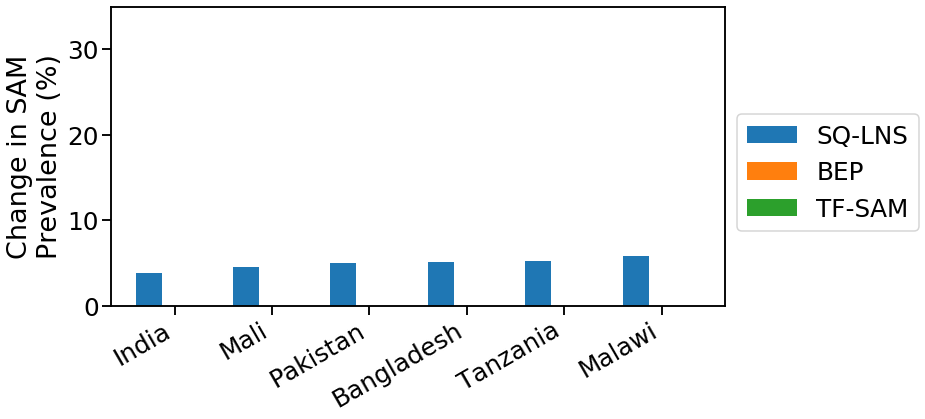

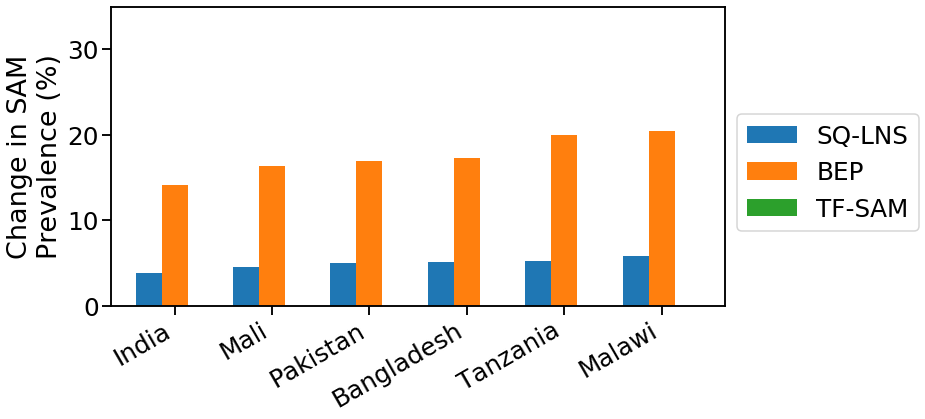

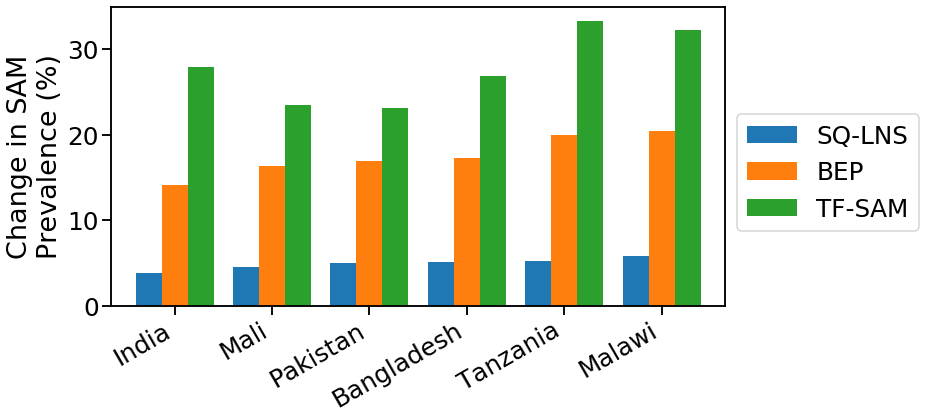

In [36]:
my_plot(cols_to_blank=['bep', 'tfsam'])
my_plot(cols_to_blank=['tfsam'])
my_plot(cols_to_blank=[])